In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import re
from collections import defaultdict
from scipy.optimize import curve_fit
az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'

/opt/anaconda3/envs/mcenv/lib/python3.10/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [3]:
L = 0.046
x_sensors = np.array([0.003, 0.008, 0.013, 0.018, 0.023, 0.028, 0.033, 0.043])
DATA_DIR = Path('data')
SKIP_INITIAL = 0
N_SAMPLES = 1500
N_TUNE = 500
N_CHAINS = 4
TARGET_ACCEPT = 0.95
MODEL_TYPES = ['SimpleForward', 'FullSolution', 'FullSolutionNewton', 'FullSolutionRobin']

In [4]:
def load_dataset(path):
    data = pd.read_csv(path, header=3)
    timestamp = data.iloc[:, 0].to_numpy()
    thermistor_temps = data.iloc[:, 3:].to_numpy()
    match = re.search(r'_(\d+)s\.csv', str(path))
    period_str = match.group(1) if match else None
    return timestamp, thermistor_temps, period_str

def load_all_datasets(data_dir, pattern='al_*.csv', skip_initial=1000):
    files = sorted(glob(str(Path(data_dir) / pattern)))
    datasets = []
    for fpath in files:
        timestamp, thermistor_temps, period_str = load_dataset(fpath)
        t = timestamp[skip_initial:] - timestamp[skip_initial]
        temp = thermistor_temps[skip_initial:, :].T
        period = float(period_str)
        omega = 2 * np.pi / period
        
        datasets.append({'t': t,'temp': temp,
            'omega': omega,'period': period_str, 'file': Path(fpath).name})
        print(f"{Path(fpath).name}: time = {period}s, ω={omega:.4f}, shape={temp.shape}")

    return datasets
datasets = load_all_datasets(DATA_DIR, skip_initial=SKIP_INITIAL)
print(f"loaded {len(datasets)} frequencies")

al_10s.csv: time = 10.0s, ω=0.6283, shape=(8, 3565)
al_15s.csv: time = 15.0s, ω=0.4189, shape=(8, 3222)
al_20s.csv: time = 20.0s, ω=0.3142, shape=(8, 1331)
al_25s.csv: time = 25.0s, ω=0.2513, shape=(8, 3526)
al_35s.csv: time = 35.0s, ω=0.1795, shape=(8, 3018)
al_40s.csv: time = 40.0s, ω=0.1571, shape=(8, 4541)
al_50s.csv: time = 50.0s, ω=0.1257, shape=(8, 3464)
al_5s.csv: time = 5.0s, ω=1.2566, shape=(8, 2655)
al_60s.csv: time = 60.0s, ω=0.1047, shape=(8, 4234)
al_70s.csv: time = 70.0s, ω=0.0898, shape=(8, 6444)
loaded 10 frequencies


In [5]:
def forward_numpy_flat(x_t_flat, *params):
    N_sensors = len(x_sensors)
    N_time = len(x_t_flat) // N_sensors
    x = x_sensors
    t = x_t_flat[:N_time]
    omega = current_omega
    model_type = current_model_type
    L = current_L
    if model_type in ['SimpleForward', 'FullSolution']:
        D, A, phi = params[:3]
        Tbar = np.array(params[3:])
        gamma, H = 0.0, 0.0
    elif model_type == 'FullSolutionNewton':
        D, gamma, A, phi = params[:4]
        Tbar = np.array(params[4:])
        H = 0.0
    elif model_type == 'FullSolutionRobin':
        D, gamma, H, A, phi = params[:5]
        Tbar = np.array(params[5:])
    if model_type == 'SimpleForward':
        beta = np.sqrt(omega / (2 * D))
        result = np.zeros((N_sensors, N_time))
        for i, xi in enumerate(x):
            decay = np.exp(-beta * xi)
            wave = decay * np.cos(omega * t - beta * xi + phi)
            result[i, :] = Tbar[i] + A * wave
        return result.flatten()
    elif model_type == 'FullSolution':
        k = np.sqrt(1j * omega / D)
        result = np.zeros((N_sensors, N_time))
        for i, xi in enumerate(x):
            transfer = np.cosh(k * (L - xi)) / np.cosh(k * L)
            wave = A * np.exp(1j * (omega * t + phi)) * transfer
            result[i, :] = Tbar[i] + np.real(wave)
        return result.flatten()
    elif model_type == 'FullSolutionNewton':
        k = np.sqrt((gamma + 1j * omega) / D)
        result = np.zeros((N_sensors, N_time))
        for i, xi in enumerate(x):
            transfer = np.cosh(k * (L - xi)) / np.cosh(k * L)
            wave = A * np.exp(1j * (omega * t + phi)) * transfer
            result[i, :] = Tbar[i] + np.real(wave)
        return result.flatten()
    elif model_type == 'FullSolutionRobin':
        k = np.sqrt((gamma + 1j * omega) / D)
        result = np.zeros((N_sensors, N_time))
        for i, xi in enumerate(x):
            num = k * np.cosh(k * (L - xi)) + H * np.sinh(k * (L - xi))
            den = k * np.cosh(k * L) + H * np.sinh(k * L)
            transfer = num / den
            wave = A * np.exp(1j * (omega * t + phi)) * transfer
            result[i, :] = Tbar[i] + np.real(wave)
        return result.flatten()

def prefit_model(data, x_sensors_local, L, model_type):
    global current_omega, current_model_type, current_L, x_sensors
    x_sensors = x_sensors_local
    current_L = L
    current_omega = data['omega']
    current_model_type = model_type
    t = data['t']
    temp = data['temp']
    N_sensors = len(x_sensors)
    x_t_flat = np.tile(t, N_sensors)
    y_flat = temp.flatten()
    
    if model_type in ['SimpleForward', 'FullSolution']:
        p0 = [8e-5, 5.0, 0.0] + list(np.mean(temp, axis=1))
        bounds = ([1e-6, 0.1, -np.pi] + [15.0]*N_sensors,
                  [5e-4, 20.0, np.pi] + [35.0]*N_sensors)
    elif model_type == 'FullSolutionNewton':
        p0 = [8e-5, 0.01, 5.0, 0.0] + list(np.mean(temp, axis=1))
        bounds = ([1e-6, 0.0, 0.1, -np.pi] + [15.0]*N_sensors,
                  [5e-4, 0.2, 20.0, np.pi] + [35.0]*N_sensors)
    elif model_type == 'FullSolutionRobin':
        p0 = [8e-5, 0.01, 1.0, 5.0, 0.0] + list(np.mean(temp, axis=1))
        bounds = ([1e-6, 0.0, 0.0, 0.1, -np.pi] + [15.0]*N_sensors,
                  [5e-4, 0.2, 10.0, 20.0, np.pi] + [35.0]*N_sensors)
    popt, _ = curve_fit(forward_numpy_flat, x_t_flat, y_flat, p0=p0, bounds=bounds, maxfev=200)
    fitted = {}
    if model_type in ['SimpleForward', 'FullSolution']:
        fitted['D'] = popt[0]
        fitted['A'] = popt[1]
        fitted['phi'] = popt[2]
        fitted['Tbar'] = popt[3:]
        fitted['gamma'] = 0.0
        fitted['H'] = 0.0
    elif model_type == 'FullSolutionNewton':
        fitted['D'] = popt[0]
        fitted['gamma'] = popt[1]
        fitted['A'] = popt[2]
        fitted['phi'] = popt[3]
        fitted['Tbar'] = popt[4:]
        fitted['H'] = 0.0
    elif model_type == 'FullSolutionRobin':
        fitted['D'] = popt[0]
        fitted['gamma'] = popt[1]
        fitted['H'] = popt[2]
        fitted['A'] = popt[3]
        fitted['phi'] = popt[4]
        fitted['Tbar'] = popt[5:]
    return fitted
prefits = defaultdict(dict)
for model_type in MODEL_TYPES:
    print(f"{model_type}:")
    for data in datasets:
        period = data['period']
        fitted = prefit_model(data, x_sensors, L, model_type)
        prefits[model_type][period] = fitted
        print(f"time = {period}: diffusivity = {fitted['D']:.2e}, gamma = {fitted['gamma']:.4f}, A={fitted['A']:.2f}, phi ={fitted['phi']:.3f}")

SimpleForward:
time = 10: diffusivity = 6.32e-05, gamma = 0.0000, A=0.51, phi =2.823
time = 15: diffusivity = 6.79e-05, gamma = 0.0000, A=0.77, phi =-1.508
time = 20: diffusivity = 7.31e-05, gamma = 0.0000, A=1.04, phi =2.936
time = 25: diffusivity = 8.21e-05, gamma = 0.0000, A=1.29, phi =-0.945
time = 35: diffusivity = 1.08e-04, gamma = 0.0000, A=1.81, phi =2.583
time = 40: diffusivity = 1.25e-04, gamma = 0.0000, A=2.07, phi =-0.631
time = 50: diffusivity = 1.60e-04, gamma = 0.0000, A=2.61, phi =1.803
time = 5: diffusivity = 5.61e-05, gamma = 0.0000, A=0.23, phi =-1.871
time = 60: diffusivity = 2.02e-04, gamma = 0.0000, A=3.16, phi =-0.226
time = 70: diffusivity = 1.00e-04, gamma = 0.0000, A=4.13, phi =-3.142
FullSolution:
time = 10: diffusivity = 6.86e-05, gamma = 0.0000, A=0.50, phi =2.802
time = 15: diffusivity = 8.31e-05, gamma = 0.0000, A=0.74, phi =-1.541
time = 20: diffusivity = 8.81e-05, gamma = 0.0000, A=1.01, phi =2.939
time = 25: diffusivity = 9.04e-05, gamma = 0.0000, A=1.

In [6]:
def build_per_freq_model_informed(data, x_sensors, L, model_type, prefit=None):
    N_sensors = len(x_sensors)
    t = data['t']
    temp = data['temp']
    omega = data['omega']
    X = x_sensors[:, None]
    LX = L - X
    T = t[None, :]
    if prefit is not None:
        D_mu, gamma_mu, H_mu, A_mu = prefit['D'] / 1e-6, prefit['gamma'], prefit.get('H', 1.0), prefit['A']
        phi_mu = prefit['phi']
        Tbar_mu = prefit['Tbar']
    else:
        D_mu, gamma_mu, H_mu, A_mu = 80.0, 0.025, 1.0, 5.0
        phi_mu, Tbar_mu= 0.0, 25.0
    with pm.Model(coords={"sensor": [f"S{i}" for i in range(N_sensors)]}) as model:
        D_scaled = pm.Normal("D_scaled", mu=D_mu, sigma=50.0)
        D = pm.Deterministic("D", D_scaled * 1e-6)
        if model_type in ['FullSolutionNewton', 'FullSolutionRobin']:
            gamma = pm.HalfNormal("gamma", sigma=1) # gamma must be strictly positive
        if model_type == 'FullSolutionRobin':
            # H = pm.HalfNormal("H", sigma=2.0)
            H = pm.Normal("H", mu=H_mu, sigma=2.0)
        A_source = pm.Normal("A_source", mu=A_mu, sigma=3.0)
        phi_source = pm.Normal("phi_source", mu=phi_mu, sigma=0.5)
        if prefit is not None:
            Tbar = pm.Normal("Tbar", mu=Tbar_mu, sigma=2.0, dims="sensor")
        else:
            Tbar = pm.Normal("Tbar", mu=25.0, sigma=5.0, dims="sensor")
        sigma = pm.HalfNormal("sigma", sigma=1.0, dims="sensor") # treating sigma per sensor

        if model_type == 'SimpleForward': # solution assuming high-frequency limit and no reflected waves
            beta = pm.math.sqrt(omega / (2 * D))
            decay = pm.math.exp(-beta * X)
            phase_term = omega * T - beta * X + phi_source
            wave = decay * pm.math.cos(phase_term)
            mu = Tbar[:, None] + A_source * wave
        
        elif model_type == 'FullSolution': # full solution with no newtonian cooling
            k_mag = pm.math.sqrt(omega / D)
            k_real = k_mag / np.sqrt(2)
            k_imag = k_mag / np.sqrt(2)
            
            cosh_kL_real = pm.math.cosh(k_real * L) * pm.math.cos(k_imag * L)
            cosh_kL_imag = pm.math.sinh(k_real * L) * pm.math.sin(k_imag * L)
            denom_L = cosh_kL_real**2 + cosh_kL_imag**2
            
            cosh_kLx_real = pm.math.cosh(k_real * LX) * pm.math.cos(k_imag * LX)
            cosh_kLx_imag = pm.math.sinh(k_real * LX) * pm.math.sin(k_imag * LX)
            
            ratio_real = (cosh_kLx_real * cosh_kL_real + cosh_kLx_imag * cosh_kL_imag) / denom_L
            ratio_imag = (cosh_kLx_imag * cosh_kL_real - cosh_kLx_real * cosh_kL_imag) / denom_L
            
            phase_term = omega * T + phi_source
            exp_real = pm.math.cos(phase_term)
            exp_imag = pm.math.sin(phase_term)
            wave_real = ratio_real * exp_real - ratio_imag * exp_imag
            mu = Tbar[:, None] + A_source * wave_real
        
        elif model_type == 'FullSolutionNewton': # full solution with newtonian cooling
            r = pm.math.sqrt(gamma**2 + omega**2)
            theta = pt.arctan2(omega, gamma)
            k_mag = pm.math.sqrt(r / D)
            k_real = k_mag * pm.math.cos(theta / 2)
            k_imag = k_mag * pm.math.sin(theta / 2)
            
            cosh_kL_real = pm.math.cosh(k_real * L) * pm.math.cos(k_imag * L)
            cosh_kL_imag = pm.math.sinh(k_real * L) * pm.math.sin(k_imag * L)
            denom_L = cosh_kL_real**2 + cosh_kL_imag**2
            
            cosh_kLx_real = pm.math.cosh(k_real * LX) * pm.math.cos(k_imag * LX)
            cosh_kLx_imag = pm.math.sinh(k_real * LX) * pm.math.sin(k_imag * LX)
            
            ratio_real = (cosh_kLx_real * cosh_kL_real + cosh_kLx_imag * cosh_kL_imag) / denom_L
            ratio_imag = (cosh_kLx_imag * cosh_kL_real - cosh_kLx_real * cosh_kL_imag) / denom_L
            
            phase_term = omega * T + phi_source
            exp_real = pm.math.cos(phase_term)
            exp_imag = pm.math.sin(phase_term)
            wave_real = ratio_real * exp_real - ratio_imag * exp_imag
            mu = Tbar[:, None] + A_source * wave_real
        
        elif model_type == 'FullSolutionRobin': # full solution with newtonian cooling and robin boundary condition on x = L
            r = pm.math.sqrt(gamma**2 + omega**2)
            theta = pt.arctan2(omega, gamma)
            k_mag = pm.math.sqrt(r / D)
            k_real = k_mag * pm.math.cos(theta / 2)
            k_imag = k_mag * pm.math.sin(theta / 2)
            
            cosh_kL_real = pm.math.cosh(k_real * L) * pm.math.cos(k_imag * L)
            cosh_kL_imag = pm.math.sinh(k_real * L) * pm.math.sin(k_imag * L)
            sinh_kL_real = pm.math.sinh(k_real * L) * pm.math.cos(k_imag * L)
            sinh_kL_imag = pm.math.cosh(k_real * L) * pm.math.sin(k_imag * L)
            
            k_coshL_real = k_real * cosh_kL_real - k_imag * cosh_kL_imag
            k_coshL_imag = k_real * cosh_kL_imag + k_imag * cosh_kL_real
            den_real = k_coshL_real + H * sinh_kL_real
            den_imag = k_coshL_imag + H * sinh_kL_imag
            den_sq = den_real**2 + den_imag**2
            
            cosh_kLx_real = pm.math.cosh(k_real * LX) * pm.math.cos(k_imag * LX)
            cosh_kLx_imag = pm.math.sinh(k_real * LX) * pm.math.sin(k_imag * LX)
            sinh_kLx_real = pm.math.sinh(k_real * LX) * pm.math.cos(k_imag * LX)
            sinh_kLx_imag = pm.math.cosh(k_real * LX) * pm.math.sin(k_imag * LX)
            
            k_cosh_real = k_real * cosh_kLx_real - k_imag * cosh_kLx_imag
            k_cosh_imag = k_real * cosh_kLx_imag + k_imag * cosh_kLx_real
            num_real = k_cosh_real + H * sinh_kLx_real
            num_imag = k_cosh_imag + H * sinh_kLx_imag
            
            ratio_real = (num_real * den_real + num_imag * den_imag) / den_sq
            ratio_imag = (num_imag * den_real - num_real * den_imag) / den_sq
            
            phase_term = omega * T + phi_source
            exp_real = pm.math.cos(phase_term)
            exp_imag = pm.math.sin(phase_term)
            wave_real = ratio_real * exp_real - ratio_imag * exp_imag
            mu = Tbar[:, None] + A_source * wave_real

        pm.Normal("obs", mu=mu, sigma=sigma[:, None], observed=temp)
    return model

In [ ]:
Path('results/traces').mkdir(parents=True, exist_ok=True)

results = defaultdict(dict)
loo_scores = defaultdict(dict)

for model_type in MODEL_TYPES:
    print(f"model: {model_type}")
    for data in datasets:
        period = data['period']
        print(f"period: {period}s; w ={data['omega']:.4f}")
        
        prefit = prefits[model_type].get(period, None)
        model = build_per_freq_model_informed(data, x_sensors, L, model_type, prefit=prefit)
        
        with model:
            trace = pm.sample(draws=N_SAMPLES,tune=N_TUNE,chains=N_CHAINS,target_accept=TARGET_ACCEPT,
                return_inferencedata=True,random_seed=42,progressbar=True,idata_kwargs={"log_likelihood": True}
            )
        
        results[model_type][period] = trace
        loo = az.loo(trace, pointwise=True)
        loo_scores[model_type][period] = loo
        trace_filename = f'results/traces/{model_type}_T{period}s.nc'
        trace.to_netcdf(trace_filename)        
        D_samples = trace.posterior['D'].values.flatten()
        print(f"diffusivity: {D_samples.mean():.6e} pm {D_samples.std():.6e}")
        if prefit is not None:
            print(f"pre-fit: {prefit['D']:.6e}")
        
        if model_type in ['FullSolutionNewton', 'FullSolutionRobin']:
            gamma_samples = trace.posterior['gamma'].values.flatten()
            print(f"gamma: {gamma_samples.mean():.6f} pm {gamma_samples.std():.6f}")
            if prefit is not None:
                print(f"pre-fit: {prefit['gamma']:.6f}")
        
        print(f"LOO: {loo.elpd_loo:.2f} pm {loo.se:.2f}")
        print()

model: SimpleForward
period: 10s; w =0.6283


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_scaled, A_source, phi_source, Tbar, sigma]


Output()

In [ ]:
from glob import glob

results = defaultdict(dict)
loo_scores = defaultdict(dict)

trace_files = sorted(glob('results/traces/*.nc'))

for trace_file in trace_files:
    filename = Path(trace_file).stem
    parts = filename.split('_T')
    model_type = parts[0]
    period = parts[1].replace('s', '')
    trace = az.from_netcdf(trace_file)
    results[model_type][period] = trace
    loo = az.loo(trace, pointwise=True)
    loo_scores[model_type][period] = loo

In [ ]:
# post-processing 
Path('results/trace_plots').mkdir(parents=True, exist_ok=True)

for model_type in MODEL_TYPES:
    for period in results[model_type].keys():
        trace = results[model_type][period]
        global_vars = ['D']
        if model_type in ['FullSolutionNewton', 'FullSolutionRobin']:
            global_vars.append('gamma')
        if model_type == 'FullSolutionRobin':
            global_vars.append('H')
        
        fig = az.plot_trace(trace, var_names=global_vars, compact=False)
        plt.suptitle(f'{model_type}, T={period}s', y=1.01)
        plt.tight_layout()
        plt.savefig(f'results/trace_plots/{model_type}_T{period}s_trace.png', dpi=150, bbox_inches='tight')
        plt.close()
        
        fig = az.plot_posterior(trace, var_names=global_vars, hdi_prob=0.95)
        plt.suptitle(f'{model_type} - T={period}s', y=1.01)
        plt.tight_layout()
        plt.savefig(f'results/trace_plots/{model_type}_T{period}s_posterior.png', dpi=150, bbox_inches='tight')
        plt.close()

In [ ]:
periods_sorted = sorted([d['period'] for d in datasets], key=float)

loo_matrix = np.zeros((len(periods_sorted), len(MODEL_TYPES)))
for i, period in enumerate(periods_sorted):
    for j, model_type in enumerate(MODEL_TYPES):
        if period in loo_scores[model_type]:
            loo_matrix[i, j] = loo_scores[model_type][period].elpd_loo
        else:
            loo_matrix[i, j] = np.nan

loo_df = pd.DataFrame(loo_matrix, index=[f"T={p}s" for p in periods_sorted], columns=MODEL_TYPES)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
im = ax.imshow(loo_matrix, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(MODEL_TYPES)))
ax.set_xticklabels(MODEL_TYPES, rotation=45, ha='right')
ax.set_yticks(range(len(periods_sorted)))
ax.set_yticklabels([f"T= {p}s" for p in periods_sorted])
ax.set_title('LOOCV: expected log predictive density\n(higher = better)')
for i in range(len(periods_sorted)):
    for j in range(len(MODEL_TYPES)):
        if not np.isnan(loo_matrix[i, j]):
            text = ax.text(j, i, f'{loo_matrix[i, j]:.0f}', 
                          ha="center", va="center", color="black", fontsize=8)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('ELPD LOO')

ax = axes[1]
loo_normalized = np.zeros_like(loo_matrix)
for i in range(len(periods_sorted)):
    row = loo_matrix[i, :]
    if not np.all(np.isnan(row)):
        row_min, row_max = np.nanmin(row), np.nanmax(row)
        if row_max > row_min:
            loo_normalized[i, :] = (row - row_min) / (row_max - row_min)
        else:
            loo_normalized[i, :] = 0.5
    else:
        loo_normalized[i, :] = np.nan

im = ax.imshow(loo_normalized, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(len(MODEL_TYPES)))
ax.set_xticklabels(MODEL_TYPES, rotation=45, ha='right')
ax.set_yticks(range(len(periods_sorted)))
ax.set_yticklabels([f"T={p}s" for p in periods_sorted])
ax.set_title('row-normalized LOO Scores')

for i in range(len(periods_sorted)):
    row = loo_normalized[i, :]
    if not np.all(np.isnan(row)):
        best_idx = np.nanargmax(row)
        ax.text(best_idx, i, '★', ha="center", va="center", 
               color="blue", fontsize=16, weight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('normalized score')
plt.tight_layout()
plt.savefig('results/loo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

for i, period in enumerate(periods_sorted):
    row = loo_matrix[i, :]
    if not np.all(np.isnan(row)):
        best_idx = np.nanargmax(row)
        best_model = MODEL_TYPES[best_idx]
        best_score = row[best_idx]
        print(f"T={period}s: {best_model} ELPD LOO = {best_score:.2f}")
loo_df.to_csv('results/loo_scores.csv')

/var/folders/ck/fw0_p4bd6hv0dl2fskcx9s2r0000gn/T/ipykernel_26539/3119936971.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


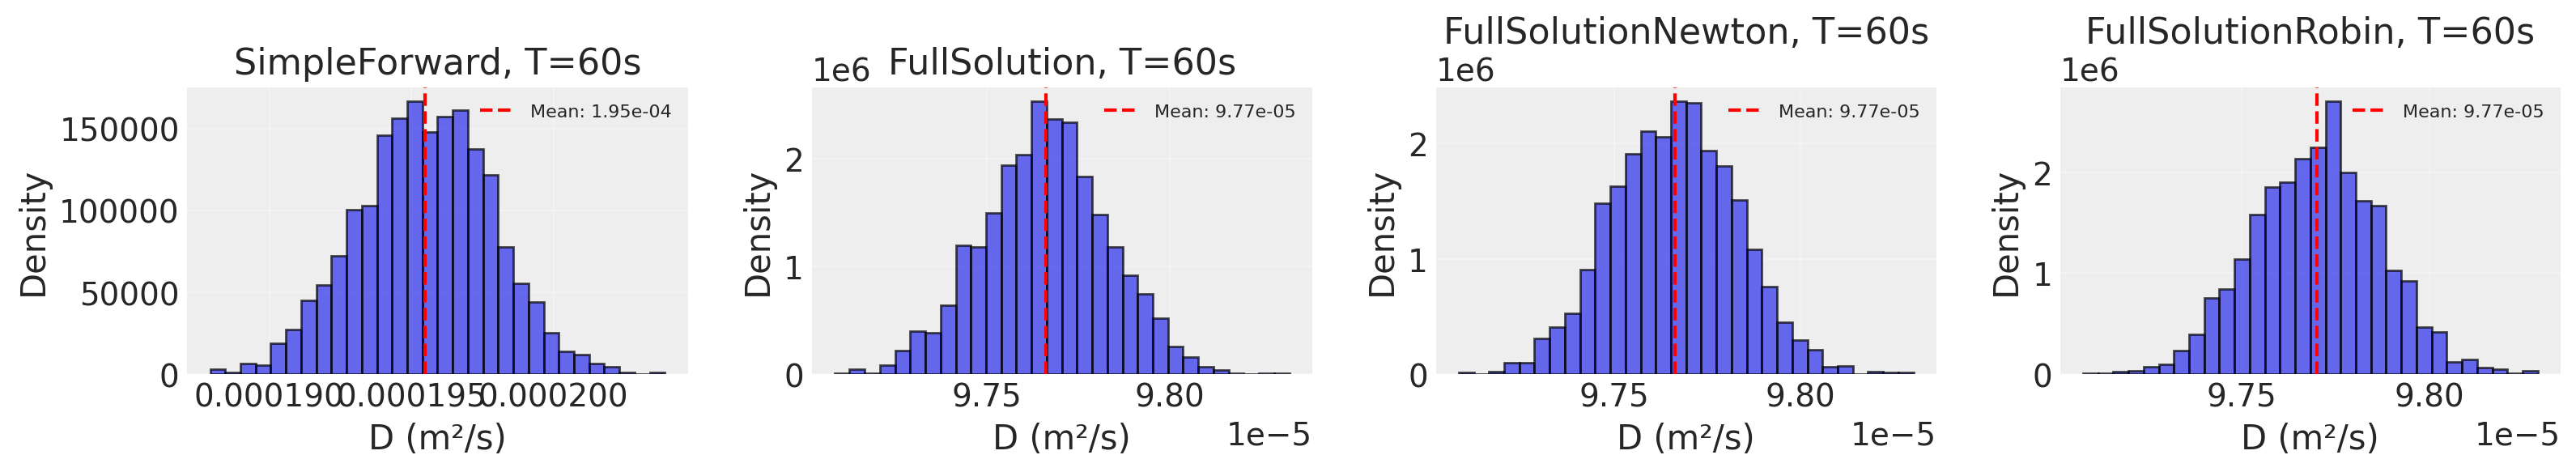

In [ ]:
n_freqs = len(datasets)
fig, axes = plt.subplots(n_freqs, 4, figsize=(16, 3*n_freqs))
axes = np.atleast_2d(axes)

periods_sorted = sorted(datasets, key=lambda d: float(d['period']))

for row, data in enumerate(periods_sorted):
    period = data['period']
    
    for col, model_type in enumerate(MODEL_TYPES):
        ax = axes[row, col]
        trace = results[model_type][period]
        
        D_samples = trace.posterior['D'].values.flatten()
        ax.hist(D_samples, bins=30, density=True, alpha=0.7, edgecolor='black')
        ax.axvline(D_samples.mean(), color='red', linestyle='--', label=f'Mean: {D_samples.mean():.2e}')
        
        ax.set_xlabel('D m2/s')
        ax.set_ylabel('density')
        ax.set_title(f'{model_type}, T={period}s')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/D_posteriors_grid.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
summary_data = []

for model_type in MODEL_TYPES:
    for period, trace in results[model_type].items():
        D_samples = trace.posterior['D'].values.flatten()
        
        row = {
            'model': model_type,
            'period_s': float(period),
            'omega': 2*np.pi/float(period),
            'D_mean': D_samples.mean(),
            'D_std': D_samples.std(),
            'D_hdi_low': np.percentile(D_samples, 2.5),
            'D_hdi_high': np.percentile(D_samples, 97.5)
        }
        
        if model_type in ['FullSolutionNewton', 'FullSolutionRobin']:
            gamma_samples = trace.posterior['gamma'].values.flatten()
            row['gamma_mean'] = gamma_samples.mean()
            row['gamma_std'] = gamma_samples.std()
            row['gamma_hdi_low'] = np.percentile(gamma_samples, 2.5)
            row['gamma_hdi_high'] = np.percentile(gamma_samples, 97.5)
        
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['model', 'period_s'])
summary_df.to_csv('results/per_frequency_summary.csv', index=False)
print("Summary saved to results/per_frequency_summary.csv")
summary_df

Summary saved to results/per_frequency_summary.csv


,model,period_s,omega,D_mean,D_std,D_hdi_low,D_hdi_high,gamma_mean,gamma_std,gamma_hdi_low,gamma_hdi_high
1,FullSolution,60.0,0.10472,0.000098,1.717341e-07,0.000097,0.000098,NaN,NaN,NaN,NaN
2,FullSolutionNewton,60.0,0.10472,0.000098,1.664879e-07,0.000097,0.000098,0.000011,0.000012,2.446767e-07,0.000044
3,FullSolutionRobin,60.0,0.10472,0.000098,1.694706e-07,0.000097,0.000098,0.000077,0.000077,2.087293e-06,0.000281
0,SimpleForward,60.0,0.10472,0.000195,2.349563e-06,0.000191,0.000200,NaN,NaN,NaN,NaN
